In [4]:
naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench301'

In [5]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [6]:
dataset = 'cifar10'
proxy = 'nwot'
data = dfs[dataset]

In [7]:
ylims = {'nwot': (550, 850)}

def plt_ylim(prox):
    if prox not in ylims:
        return
    plt.ylim(ylims[prox][0], ylims[prox][1])

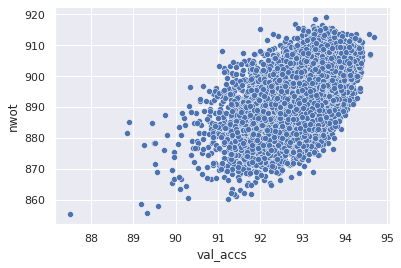

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.scatterplot(data=data, x='val_accs', y=proxy)
#plt.xlim(70, 91)
#plt_ylim(proxy)
plt.show()

In [43]:
from zc_combine.operations import parse_ops_nb301, count_all_ops, get_nb301_cell

count_set = {2, 3, 4, 5, 6}
ops = parse_ops_nb301(data)
ops = get_nb301_cell(ops, both=True)
count_all_ops(data, ops, count_set)

In [44]:
# NB201 op names and edge indices to edges for convenience
OPS = ["max_pool_3x3", "avg_pool_3x3", "skip_connect", "sep_conv_3x3", "sep_conv_5x5", "dil_conv_3x3", "dil_conv_5x5"]

# TODO edges?

## NASWOT bias
NASWOT seems to be highly biased towards the number of convolutions. Let us define `count` == number of `Conv3x3` + number of `Conv5x5` (both dil and sep) in a cell.

Then, plotting every count (from 1 to 6) as a different colour, we get this:

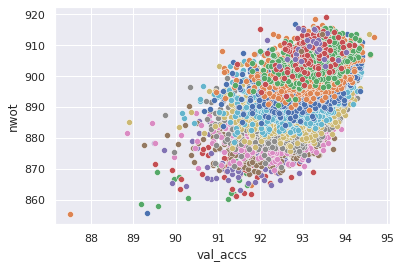

In [62]:
from zc_combine.operations import plot_clouds

plot_clouds(data, (3,4,5,6), proxy, vmax=17)
#plt_ylim(proxy)
plt.show()

Let us zoom on a cloud, let's say `count` == 4 (red if plotting from `count` == 1).

Then, the clouds don't seem to depend on the number of `Conv3x3`.

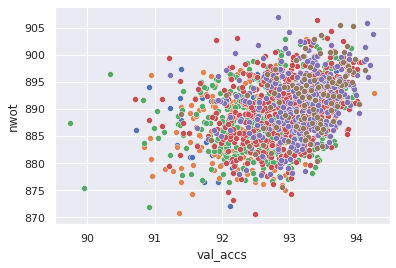

In [46]:
zoom = 8

data_zoom = data[(data[str((3,4,5,6))] == zoom)]
plot_clouds(data_zoom, data_zoom[str((2,))], proxy, vmax=6)
#plt.xlim(69, 93)
#plt.ylim(700, 820)
plt.show()

If we examine the clusters, the lower scored networks have more pooling ops and dil convs, while upper scored networks have more skip connections and sep convs.

In [28]:
import numpy as np
from zc_combine.operations import filter_by_range

def get_op_array(df):
    ops = parse_ops_nb301(df)
    ops = get_nb301_cell(ops, both=True)
    return np.array(ops)

ops_1 = get_op_array(filter_by_range(data_zoom, proxy, 0, 880))
ops_2 = get_op_array(filter_by_range(data_zoom, proxy, 880, 890))
ops_3 = get_op_array(filter_by_range(data_zoom, proxy, 890, 900))

In [55]:
np.unique(ops_1.flatten(), return_counts=True)[1] / (ops_1.shape[0] * ops_1.shape[1])

array([0.18247126, 0.18821839, 0.12931034, 0.08405172, 0.0704023 ,
       0.17816092, 0.16738506])

In [56]:
np.unique(ops_2.flatten(), return_counts=True)[1] / (ops_2.shape[0] * ops_2.shape[1])

array([0.17598123, 0.16972412, 0.15429465, 0.10658419, 0.11127702,
       0.14071388, 0.14142491])

In [57]:
np.unique(ops_3.flatten(), return_counts=True)[1] / (ops_3.shape[0] * ops_3.shape[1])

array([0.15817901, 0.16373457, 0.17808642, 0.13842593, 0.14436728,
       0.10756173, 0.10964506])

## Conclusion
NASWOT score on NB301 (DARTS searchspace?) is still heavily biased towards the number of convolutions. However, the score is less regular than on the simpler NB

In [63]:
data

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,...,"(2, 3, 5)","(2, 3, 6)","(2, 4, 5)","(2, 4, 6)","(2, 5, 6)","(2, 3, 4, 5)","(2, 3, 4, 6)","(2, 3, 5, 6)","(2, 4, 5, 6)","(2, 3, 4, 5, 6)"
0,"(((0, 6), (1, 4), (0, 0), (1, 5), (1, 4), (3, ...",93.459999,1763.570304,0.278703,169.285120,54.205917,-1.016964,-64.947013,674.346436,892.207239,...,4,5,9,10,7,9,10,7,12,12
1,"(((0, 4), (1, 5), (0, 6), (2, 2), (1, 0), (3, ...",92.790001,1719.284287,0.408550,166.336000,79.345772,-6.383812,-64.978063,696.573425,895.794615,...,7,7,7,7,6,10,10,9,9,12
2,"(((0, 4), (1, 6), (0, 2), (1, 0), (0, 0), (1, ...",93.320000,2107.323702,0.204066,145.413632,49.157295,-4.990181,-64.921424,514.982910,885.212872,...,5,8,3,6,5,6,9,8,6,9
3,"(((0, 3), (1, 3), (0, 5), (2, 0), (2, 1), (3, ...",92.809998,1793.044846,0.259312,157.939200,65.735664,-1.175217,-64.880813,619.798401,888.425023,...,6,5,4,3,4,7,6,7,5,8
4,"(((0, 6), (1, 4), (0, 3), (2, 2), (0, 0), (3, ...",92.919998,1832.459174,0.227962,152.385024,50.767960,-0.533310,-64.909777,565.735718,888.114857,...,6,5,8,7,6,9,8,7,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11216,"(((0, 6), (1, 5), (0, 5), (2, 5), (1, 0), (3, ...",92.919998,1679.052704,0.209306,167.384576,52.821743,-2.142632,-65.067712,718.766357,897.881583,...,8,7,8,7,10,10,9,12,12,14
11217,"(((0, 6), (1, 4), (0, 4), (2, 3), (2, 4), (3, ...",92.750000,1766.546085,0.585298,209.344000,111.664543,-3.051392,-65.005401,933.984375,907.282405,...,6,8,8,10,8,10,12,10,12,14
11218,"(((0, 5), (1, 0), (0, 4), (2, 6), (2, 4), (3, ...",92.080002,1965.672082,0.265882,155.719168,58.341690,-7.725037,-65.024960,563.792419,886.417815,...,5,3,7,5,7,7,5,7,9,9
11219,"(((0, 6), (1, 5), (0, 0), (1, 6), (0, 2), (2, ...",92.550003,1691.945664,0.152586,150.967808,38.095749,-3.256350,-64.959636,537.478882,891.299586,...,7,8,8,9,11,8,9,11,12,12
